In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import modeling_tools as mt
import murmurhash as mhash

from sklearn.linear_model import LogisticRegression 


from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.utils.multiclass import unique_labels


from collections import Counter


In [2]:
labeled_data = pd.read_pickle('../data/labeled_data_pos_ont_nn.pkl')
drop_trash = (labeled_data['Aggr.Label'] < 90) & (labeled_data['NN_bool'] == False)
labeled_data = labeled_data[drop_trash]

In [3]:
pos_features = ['Adjective', 'Verb', 'Noun']
ont_features = ['Underspecified', 'Artifact', 'Object', 'Group', 'Human', 'Natural', 'LanguageRepresentation', 'Living', 'GeopoliticalPlace', 'BodyPart', 'Instrument', 'Place', '3rdOrderEntity', 'Mental', 'Purpose', 'Social', 'Institution', 'Plant', 'Imagerepresentation', 'Creature', 'Animal', 'Comestible', 'Quantity', 'Building', 'Substance', 'Part', 'Property', 'BoundedEvent', 'Agentive', 'Communication', 'Garment', 'Furniture', 'Vehicle', '1stOrderEntity', 'Covering', 'Liquid', 'Time', 'UnboundedEvent', 'Physical', 'Dynamic', 'Domain', 'Existence', 'Location', 'Manner', 'Container', 'Condition', 'Static', '2ndOrderEntity', 'Phenomenal', 'MoneyRepresentation', 'Experience', 'Relation', 'Form', 'Representation', 'Stimulating', 'Colour', 'Cause', 'Occupation', 'Possession', 'Artwork', 'Software']
numerical_features = ['Raw_len', 'Raw_word_count']
categorical_features = ['Label', 'Aggr.Label', 'Source', 'CoderId']
text_features = ['Lemma_stripped', 'Raw', 'Lemma']
fastt_features = ['Raw_FT_mean', 'Lemma_FT_mean']
features = pos_features + ont_features + numerical_features + text_features + fastt_features + categorical_features

fastt = 'Raw_FT_mean'
corpus = 'Lemma'
target = 'Aggr.Label'
#target = 'Label'


train_X, validation_X, train_y, validation_y = train_test_split(
    labeled_data[features],
    labeled_data[target],
    test_size=0.33,
    random_state=1,
    stratify=labeled_data[target])

In [4]:
class EnsembleClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, binary_clf, binary_clf_params, bucket_clf, bucket_clf_params, judge):
        self.binary_clf = binary_clf
        self.binary_clf_params = binary_clf_params
        self.bucket_clf = bucket_clf
        self.bucket_clf_params = bucket_clf_params
        self.judge = judge
        
    def get_buckets(self, counted):
        counted_sum = sum(counted.values())
        buckets = []
        index = 0
        for c, v in counted.most_common():
            if index == 0:
                sum_left = counted_sum
                sum_bucket = 0
                new_bucket = []

            new_bucket.append(c)
            sum_bucket += v
            sum_left -= v

            if sum_bucket >= sum_left:
                buckets.append(new_bucket)
                new_bucket = []
                sum_bucket = 0
            index += 1
            if index == len(counted) and len(new_bucket) > 0:
                buckets.append(new_bucket)
        return buckets
    
    def get_vs_all(self, buckets):
        bucket_vs_all = []
        for l_index in range(len(buckets)):
            vs_all = []
            if l_index+1 < len(buckets):
                for r_index in range(l_index+1, len(buckets)):
                    vs_all += buckets[r_index]
                bucket_vs_all.append((buckets[l_index], vs_all))
        return bucket_vs_all
 
    def fit(self, X, y):

        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y
        self.y_list_ = y.tolist()
        self.y_counts_ = Counter(self.y_list_)
        
        self.buckets_ = self.get_buckets(self.y_counts_)
        self.vs_all_ = self.get_vs_all(self.buckets_)

        self.len_b_ = len(self.vs_all_)

        self.vs_all_indicies_ = []
        self.buckets_indicies_ = []
        for bucket, rest in self.vs_all_:
            bucket_indices = []
            rest_indices = []
            #for index, value in self.y_.iteritems():
            
            for index in range(len(self.y_list_)):
                if self.y_list_[index] in bucket:
                    bucket_indices.append(index)
                if self.y_list_[index] in rest:
                    rest_indices.append(index)
                    
            self.vs_all_indicies_.append(rest_indices)
            self.buckets_indicies_.append(bucket_indices)

        self.binary_clfs_ = [self.binary_clf(**self.binary_clf_params) for _ in range(self.len_b_)]
        
        for index, clf in enumerate(self.binary_clfs_):

            fit_y = []
            fit_x_index = []
            for i in range(len(self.y_list_)):
                if i in self.buckets_indicies_[index]:
                    fit_y.append(0)
                    fit_x_index.append(i)
                if i in self.vs_all_indicies_[index]:
                    fit_y.append(1)
                    fit_x_index.append(i)
                    
            fit_x = self.X_[fit_x_index]
            
            clf.fit(fit_x, fit_y)

        self.bucket_clfs_ = [self.bucket_clf(**self.bucket_clf_params) for _ in range(self.len_b_)]
        
        for index, clf in enumerate(self.bucket_clfs_):
            
            bucket_y = [y for i, y in enumerate(self.y_list_) if i in self.buckets_indicies_[index]]
            bucket_x = self.X_[self.buckets_indicies_[index]]
            
            clf.fit(bucket_x, bucket_y)
            
        '''
        judge_train = []

        for index in range(self.len_b_):
            
            judge_train.append(self.binary_clfs_[index].predict(self.X_))
            judge_train.append(self.bucket_clfs_[index].predict(self.X_))
             
        self.judge_train_t_ = np.array(judge_train).T

        self.judge.fit(self.judge_train_t_, self.y_list_)
        '''
        return self

    def predict(self, X):
        
        '''
        votes = []
        
        for index in range(self.len_b_):
            votes.append(self.binary_clfs_[index].predict(X))
            votes.append(self.bucket_clfs_[index].predict(X))

        votes_t = np.array(votes).T 
        
        print(list(votes_t))
        
        #return votes_t
        preds = self.judge.predict(votes_t)
        
        '''
        
        len_x = X.shape[0]
        
        preds = np.ones(len_x) * 12
        
        predicted = []
        for index in range(self.len_b_):
            
            split = self.binary_clfs_[index].predict(X)

            in_bucket = [i for i in range(len_x) if split[i] == 0 and i not in predicted]
            preds[in_bucket] = self.bucket_clfs_[index].predict(X[in_bucket])
            
            predicted += in_bucket


        return preds

In [5]:
vectorizer = TfidfVectorizer(**{'max_df': 0.3, 'max_features': None, 'norm': 'l2', 'strip_accents': 'ascii', 'use_idf': False})
train_x = vectorizer.fit_transform(train_X[corpus])
validation_x = vectorizer.transform(validation_X[corpus])

In [6]:
clf = EnsembleClassifier(LogisticRegression, {'solver': 'lbfgs'}, MultinomialNB, {'alpha': 0.001}, MultinomialNB(alpha=0.001))

clf.fit(train_x, train_y)
preds = clf.predict(validation_x)
np.mean(preds == validation_y)

C:\Users\nils\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.4555510036870135

(24, 24)


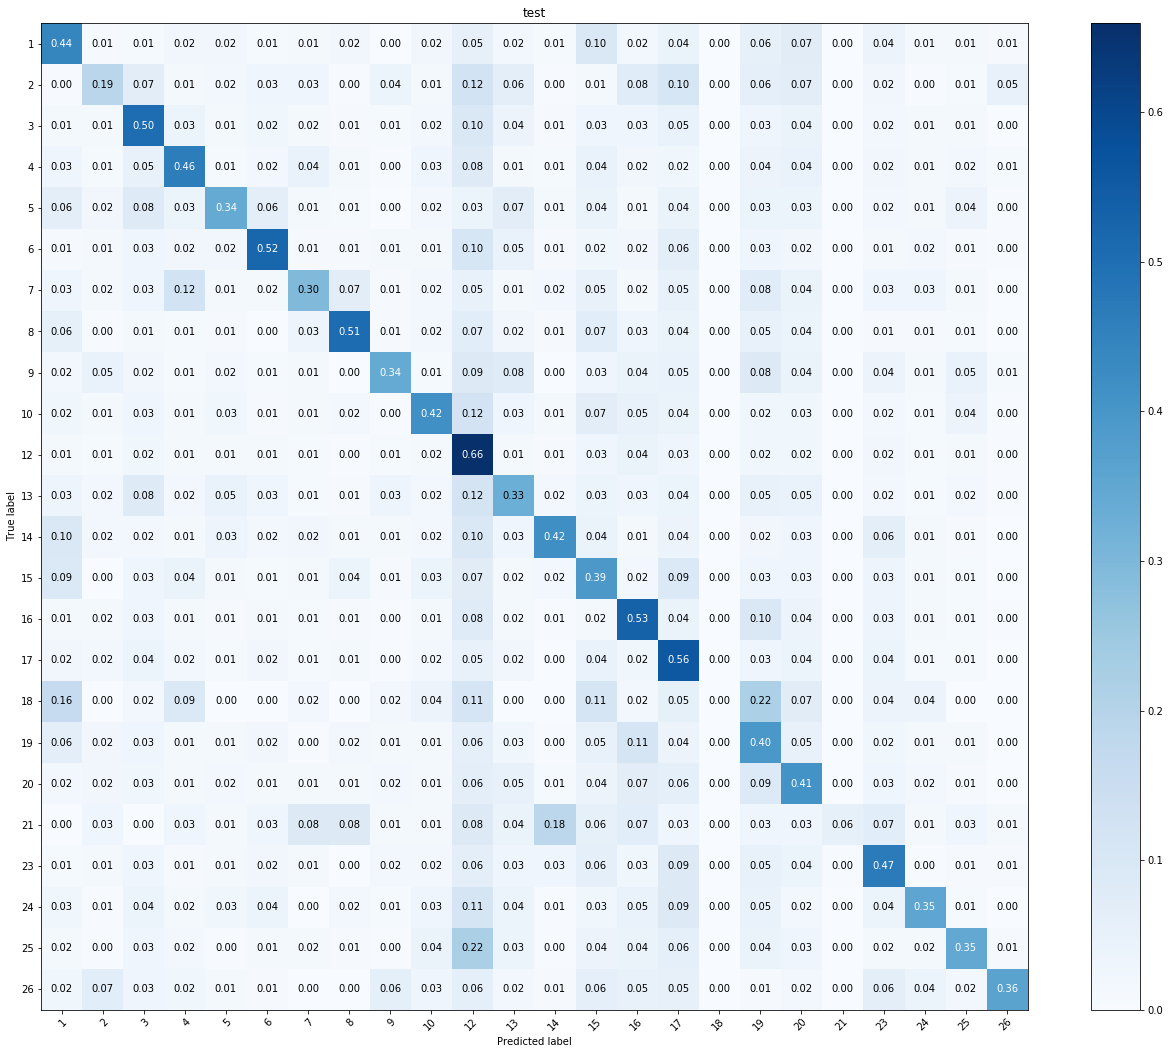

In [7]:
testy = mt.plot_cf(validation_y, preds, title = 'test')